Saving petase-sequences.txt to petase-sequences (1).txt
Loaded 4987 unique sequences
Using device: cuda
Embeddings shape: (4987, 1024)
PCA explained variance (first 5): [1.0000000e+00 1.5554113e-07 2.0654910e-11 8.0529663e-12 3.3459578e-12]
Clusters formed: [0 1 2]
Saved CSV: petase_families_pca.csv


Saving zero_shot_wt_esm_ranking.csv to zero_shot_wt_esm_ranking.csv
Sequences without ranking: 0
Representative PETase sequences (ranking-based):
   cluster_id       score                                           sequence
0           0  221.189453  SVAAQRGTFATAELTVPPGNGFNGGKIYYPTDTSLGTWAAVAAVPG...
1           1  172.251953  AAVNGPFANTSVAVPTGYGFNGGRIYYPTDTSQGTFGAIAISPGYT...
2           2  205.095703  AAQRGTFATAQMSVAPGNGFNGGKIYYPTDTSLGTWGAIAAVPGYT...


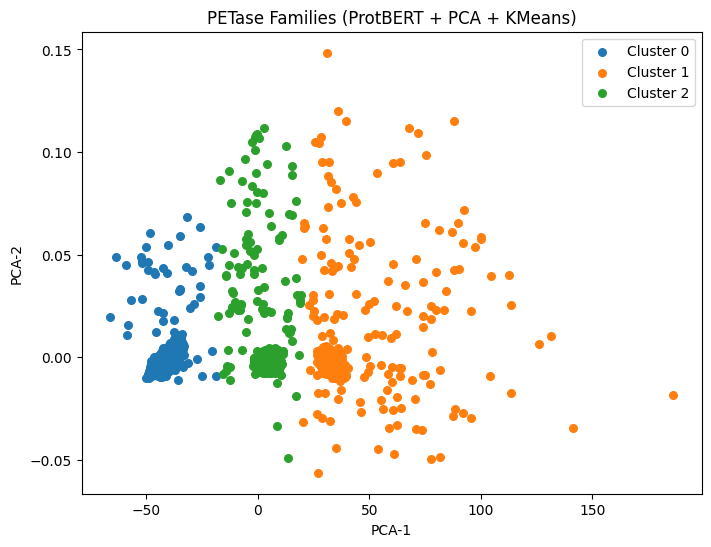

In [3]:
# ==========================================
# ProtBERT PETase Clustering (PCA-based)
# ==========================================

# -------------------------------
# Step 0: Install dependencies
# -------------------------------
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers scikit-learn pandas matplotlib biopython

# -------------------------------
# Step 1: Upload sequences
# -------------------------------
from google.colab import files
import pandas as pd
from Bio import SeqIO

uploaded = files.upload()
filename = list(uploaded.keys())[0]

ext = filename.split('.')[-1].lower()
if ext in ["fa", "fasta"]:
    sequences = [str(r.seq).upper() for r in SeqIO.parse(filename, "fasta")]
else:
    sequences = (
        pd.read_csv(filename, header=None)[0]
        .astype(str)
        .str.upper()
        .str.strip()
        .tolist()
    )

# Remove duplicate sequences while preserving order
sequences = list(dict.fromkeys(sequences))
sequences = [s for s in sequences if s.strip().upper() != "SEQUENCE"]

print(f"Loaded {len(sequences)} unique sequences")

# -------------------------------
# Step 2: Load ProtBERT
# -------------------------------
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = BertTokenizer.from_pretrained(
    "Rostlab/prot_bert", do_lower_case=False
)
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)
model.eval()

# -------------------------------
# Step 3: Generate embeddings (SAFE)
# -------------------------------
def get_protbert_embeddings(sequences, batch_size=4):
    embeddings = []
    kept_sequences = []

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        for seq in batch:
            if not seq:
                continue

            seq_spaced = " ".join(seq)
            tokens = tokenizer(seq_spaced, return_tensors="pt").to(device)

            with torch.no_grad():
                out = model(**tokens)

            emb = out.pooler_output.squeeze().cpu().numpy()
            embeddings.append(emb)
            kept_sequences.append(seq)

    embeddings = np.vstack(embeddings)
    return embeddings, kept_sequences

embeddings, valid_sequences = get_protbert_embeddings(sequences)

assert len(valid_sequences) == embeddings.shape[0]
print("Embeddings shape:", embeddings.shape)

# Save checkpoint
np.savez(
    "protbert_data.npz",
    sequences=np.array(valid_sequences, dtype=object),
    embeddings=embeddings
)

# -------------------------------
# Step 4: PCA reduction
# -------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)

pca = PCA(n_components=10, random_state=42)
emb_pca = pca.fit_transform(emb_scaled)

print("PCA explained variance (first 5):",
      pca.explained_variance_ratio_[:5])

# -------------------------------
# Step 5: KMeans clustering
# -------------------------------
from sklearn.cluster import KMeans

k = 3  # tune this
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(emb_pca)

print("Clusters formed:", np.unique(cluster_labels))

# -------------------------------
# Step 6: Build aligned DataFrame
# -------------------------------
df = pd.DataFrame({
    "sequence": valid_sequences,
    "cluster_id": cluster_labels,
    "pca_1": emb_pca[:, 0],
    "pca_2": emb_pca[:, 1]
})

df.to_csv("petase_families_pca.csv", index=False)
print("Saved CSV: petase_families_pca.csv")

# -------------------------------
# Step 7: Representative sequences
# -------------------------------

# -------------------------------
# Step 8: PCA visualization
# -------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cid in sorted(df["cluster_id"].unique()):
    idx = df["cluster_id"] == cid
    plt.scatter(
        df.loc[idx, "pca_1"],
        df.loc[idx, "pca_2"],
        label=f"Cluster {cid}",
        s=30
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PETase Families (ProtBERT + PCA + KMeans)")
plt.legend()
plt.show()

In [4]:
# -------------------------------
# Step 7: Representative sequences (ranking-based)
# -------------------------------

df = pd.read_csv("petase_families_pca.csv")

df["sequence"] = (
    df["sequence"]
    .astype(str)
    .str.upper()
    .str.strip()
)

uploaded = files.upload()
filename = list(uploaded.keys())[0]

rank_df = pd.read_csv(filename)

rank_df["sequence"] = (
    rank_df["sequence"]
    .astype(str)
    .str.upper()
    .str.strip()
)

# Merge clustering results with ranking
df_ranked = df.merge(
    rank_df,
    on="sequence",
    how="left"
)

print("Sequences without ranking:",
      df_ranked["score"].isna().sum())

representatives = (
    df_ranked
    .sort_values(
        ["cluster_id", "score"],
        ascending=[True, False]  # highest score first
    )
    .groupby("cluster_id", as_index=False)
    .first()
)

print("Representative PETase sequences (ranking-based):")
print(representatives[["cluster_id", "score", "sequence"]])

with open("petase_representatives_wt_ranking.fasta", "w") as f:
    for _, row in representatives.iterrows():
        f.write(f">cluster_{row['cluster_id']}\n{row['sequence']}\n")



Saving zero_shot_wt_esm_ranking.csv to zero_shot_wt_esm_ranking (1).csv
Sequences without ranking: 0
Representative PETase sequences (ranking-based):
   cluster_id       score                                           sequence
0           0  221.189453  SVAAQRGTFATAELTVPPGNGFNGGKIYYPTDTSLGTWAAVAAVPG...
1           1  172.251953  AAVNGPFANTSVAVPTGYGFNGGRIYYPTDTSQGTFGAIAISPGYT...
2           2  205.095703  AAQRGTFATAQMSVAPGNGFNGGKIYYPTDTSLGTWGAIAAVPGYT...


In [ ]:
total_sequences = len(df['sequence'])
unique_sequences = len(df['sequence'].unique())

if total_sequences > unique_sequences:
    print(f"Yes, there are {total_sequences - unique_sequences} repeated sequences.")
    print("\nExamples of repeated sequences:")
    repeated_sequences = df['sequence'][df['sequence'].duplicated(keep=False)].sort_values()
    for i, seq in enumerate(repeated_sequences.head(10)):
        print(f"{i+1}. {seq}")
else:
    print("No, there are no repeated sequences.")

Yes, there are 314 repeated sequences.

Examples of repeated sequences:
1. AADGPLATAAYTVPRPSGYGSGTVTYPKARGSYPGVVLMPGYQGTQENLRWLAPRLASWGFVVINVGTNTLTDDPESRGRQIRAAGTQLLALGKAPRNPLSGKLNGTLGAAGHSMGGGGVMAALRDDPRFRAGVPTAPYHPKGNFSSVTEPTFFLTCQSDPVAHGDTFAVPWYNSMSGAEKLYIEVPGDHLCPMTGYGAKAKQGKWIVSFFSLWLRADTRFSPFLCGPARDADKNDTSLVTRWMDTCP
2. AADGPLATAAYTVPRPSGYGSGTVTYPKARGSYPGVVLMPGYQGTQENLRWLAPRLASWGFVVINVGTNTLTDDPESRGRQIRAAGTQLLALGKAPRNPLSGKLNGTLGAAGHSMGGGGVMAALRDDPRFRAGVPTAPYHPKGNFSSVTEPTFFLTCQSDPVAHGDTFAVPWYNSMSGAEKLYIEVPGDHLCPMTGYGAKAKQGKWIVSFFSLWLRADTRFSPFLCGPARDADKNDTSLVTRWMDTCP
3. AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPTDTSQTYGAVVIVPGFISVWAQLNWLGPRLASQGFVVIGIETSVITDLPDPRGDQALAALDWATTRSPVASRIDRTRLAAAGWSMGGGGLRRAALQRPSLKAIVGMAPWNGERNWSAVTVPTLFFGGSSDAVASPNDHAKPFYNSITRAEKDYIELRNADHFFPTSANTTMAKYFISWLKRWVDNDTRYTQFLCPGPSTGLFAPVSASMNTCPF
4. AADNPYQRGPDPTNASIEAATGPFAVGTQPIVGASGFGGGQIYYPTDTSQTYGAVVIVPGFISVWAQLNWLGPRLASQGFVVIGIETSVITDLPDPRGDQALAALDWATTRSPVASRIDRTRLAAAGWSMGGGGLRRAALQRPSLKAIVGMAPWNGER